# Solution to exercises for week 41-42
##### Brage Wiseth, Eirik Jahr, Felix Cameren


##### week 41

1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression of the gradients

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate), again using the analytical expression of the gradients.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

##### week 42 same as week 41 but using automatic differentiation

1. A plain gradient descent with a fixed learning rate (you will need to tune it) using automatic differentiation. Compare this with the analytical expression of the gradients you obtained last week. Feel free to use **Autograd** as Python package or **JAX**. You can use the examples form last week.

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Compare this with the analytical expression of the gradients you obtained last week.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD using automatic differentiation..

5. Add RMSprop and Adam to your library of methods for tuning the learning rate. Again using automatic differentiation.

## Data

Text(0.5, 1.0, 'Scatter plot of noisy data')

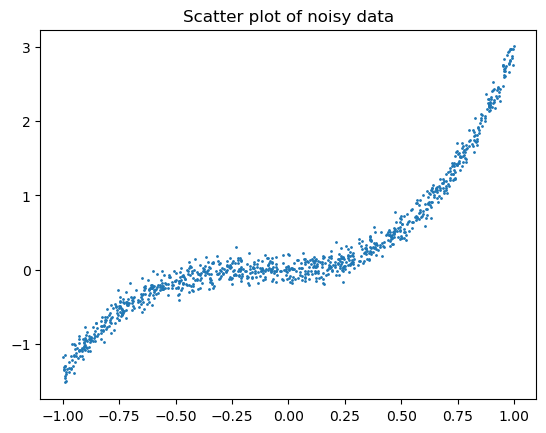

In [14]:
import numpy as np
from matplotlib import pyplot as plt


def f(x):
    return 0.2*x + 0.8*x**2 + 2*x**3

rng = np.random.default_rng(1234)
x = rng.uniform(-1, 1, size=(1000,))
y = f(x) + rng.normal(0, 0.1, size=(1000,))
plt.scatter(x, y, s=1)
plt.title("Scatter plot of noisy data")

## Preprocessing

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(degree=3, include_bias=False)
scaler = StandardScaler()

X = poly.fit_transform(x.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=1234)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_mean = y_train.mean()
y_train_scaled = y_train - y_train_mean

## Methods
### Parent class for all methods

In [28]:
def MSE(y_pred, y):
    return np.mean((y_pred - y)**2)

def MSE_Ridge(y_pred, y, w, alpha):
    return np.mean((y_pred - y)**2) + alpha*np.sum(w**2)


# Super class for all linear regression models
class NumpyLinReg():

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001):
        self.bias = bias
        self.eta = eta
        self.epochs = epochs
        self.tol = tol

    def fit(self, X_train, t_train, X_val=None, t_val=None):
        (N, m) = X_train.shape

        self.weights = np.zeros(m)

        if (X_val is None) or (t_val is None): 
            for e in range(self.epochs):
                self.learn(X_train, t_train, N)

        else:
            self.loss = np.zeros(self.epochs)
            for e in range(self.epochs):
                self.learn(X_train, t_train, N) 
                self.loss[e] = MSE(X_val @ self.weights, t_val)
                if e > 0 and np.abs(self.loss[e] - self.loss[e-1]) < self.tol:
                    break



    def predict(self, X):
        return X @ self.weights

    def learn(self, X, t, N):
        pass

### Analytical

In [17]:
class AnalyticalLinReg(NumpyLinReg):

    def fit(self, X_train, t_train, X_val=None, t_val=None):
        (N, m) = X_train.shape
        self.weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ t_train

### Gradient descent with hessian matrix inverse (gets computationaly heavy real quick)

In [18]:
class HessianInvGD(NumpyLinReg):

    def learn(self, X, t, N):
        y = self.predict(X)
        grad = (2.0/N) * X.T @ (y - t)
        hessian = (2.0/N) * X.T @ X
        self.weights -= np.linalg.inv(hessian) @ grad

### Standard gradient descent (with optional momentum)

In [19]:
class SGD(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, gamma=0):
        super().__init__(bias, eta, epochs, tol)
        self.gamma = gamma

    def learn(self, X, t, N):
        gradient = 2.0/N * X.T @ (X @ self.weights - t)
        change = self.eta*gradient + self.gamma * change
        self.weights -= change

### Ridge gradient descent (with optional momentum)

In [20]:
class RidgeGD(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, alpha=0.1, gamma=0):
        super().__init__(bias, eta, epochs, tol)
        self.alpha = alpha
        self.gamma = gamma

    def learn(self, X, t, N):
        gradient = 2.0/N * X.T @ (X @ self.weights - t) + 2*self.alpha*self.weights
        change = self.eta*gradient + self.gamma * change
        self.weights -= change

### Adagrad (with optional momentum)

In [21]:
class Adagrad(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, epsilon=1e-8, gamma=0):
        super().__init__(bias, eta, epochs, tol)
        self.gamma = gamma
        self.epsilon = epsilon
        self.G = 0

    def learn(self, X, t, N):
        gradient = 2.0/N * X.T @ (X @ self.weights - t)
        self.G += gradient**2
        change = self.eta*gradient / (np.sqrt(self.G) + self.epsilon) + self.gamma * change
        self.weights -= change 

### RMSprop

In [22]:
class RMSprop(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, epsilon=0.0001, decay=0.9):
        super().__init__(bias, eta, epochs, tol)
        self.epsilon = epsilon
        self.G = 0
        self.decay = decay

    def learn(self, X, t, N):
        gradient = 2.0/N * X.T @ (X @ self.weights - t)
        self.G = self.decay * self.G + (1-self.decay) * gradient**2
        self.weights -= self.eta * gradient / (np.sqrt(self.G) + self.epsilon)

### Adam

In [23]:
class Adam(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, epsilon=0.0001, beta1=0.9, beta2=0.999):
        super().__init__(bias, eta, epochs, tol)
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.beta1 = beta1
        self.beta2 = beta2

    def learn(self, X, t, N):
        gradient = 2.0/N * X.T @ (X @ self.weights - t)
        self.m = self.beta1 * self.m + (1-self.beta1) * gradient
        self.v = self.beta2 * self.v + (1-self.beta2) * gradient**2
        m_hat = self.m / (1-self.beta1)
        v_hat = self.v / (1-self.beta2)
        self.weights -= self.eta * m_hat / (np.sqrt(v_hat) + self.epsilon)

## Automatic differentiation
### Automatic standard gradient descent (with optional momentum)

In [24]:
import jax.numpy as jnp
from jax import grad


class JaxLinReg(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, gamma=0):
        super().__init__(bias, eta, epochs, tol)
        self.gamma = gamma

    def learn(self, X, t, N):
        gradient = grad(MSE)(self.weights, X, t) 
        change = self.eta*gradient + self.gamma * change
        self.weights -= change
    


### Automatic ridge gradient descent (with optional momentum)

In [ ]:
class JaxLinRegRidge(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, alpha=0.1, gamma=0):
        super().__init__(bias, eta, epochs, tol)
        self.alpha = alpha
        self.gamma = gamma

    def learn(self, X, t, N):
        gradient = grad(MSE_Ridge)(self.weights, X, t, self.alpha)
        change = self.eta*gradient + self.gamma * change
        self.weights -= change

### Automatic adagrad (with optional momentum)

In [ ]:
class JaxLinRegHessianInv(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, epsilon=1e-8, gamma=0):
        super().__init__(bias, eta, epochs, tol)
        self.gamma = gamma
        self.epsilon = epsilon
        self.G = 0

    def learn(self, X, t, N):
        gradient = grad(MSE)(self.weights, X, t) 
        self.G += gradient**2
        change = self.eta*gradient / (np.sqrt(self.G) + self.epsilon) + self.gamma * change
        self.weights -= change 

### Automatic RMSprop

In [ ]:
class JaxLinRegRMSprop(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, epsilon=0.0001, decay=0.9):
        super().__init__(bias, eta, epochs, tol)
        self.epsilon = epsilon
        self.G = 0
        self.decay = decay

    def learn(self, X, t, N):
        gradient = grad(MSE)(self.weights, X, t)
        self.G = self.decay * self.G + (1-self.decay) * gradient**2
        self.weights -= self.eta * gradient / (np.sqrt(self.G) + self.epsilon)

### Automatic Adam

In [26]:
class JaxLinRegAdam(NumpyLinReg):

    def __init__(self, bias=0, eta=0.1, epochs=100, tol=0.001, epsilon=0.0001, beta1=0.9, beta2=0.999):
        super().__init__(bias, eta, epochs, tol)
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.beta1 = beta1
        self.beta2 = beta2

    def learn(self, X, t, N):
        gradient = grad(MSE)(self.weights, X, t)
        self.m = self.beta1 * self.m + (1-self.beta1) * gradient
        self.v = self.beta2 * self.v + (1-self.beta2) * gradient**2
        m_hat = self.m / (1-self.beta1)
        v_hat = self.v / (1-self.beta2)
        self.weights -= self.eta * m_hat / (np.sqrt(v_hat) + self.epsilon)

## Results

In [25]:
etas = [0.01, 0.1, 0.5, 1]
epochs = 1000
tol = 0.0001
gammas = [0, 0.9, 0.99, 0.999]
alphas = [0.01, 0.1, 0.5, 1]
epsilon = 1e-8
decay = 0.9
beta1 = 0.9
beta2 = 0.999


analytical = AnalyticalLinReg()
analytical.fit(X_train, y_train_scaled)
print("Analytical solution: ", MSE(analytical.predict(X_test), y_test))

for i, eta in enumerate(etas):
    hessianGd = HessianInvGD(eta=eta, epochs=epochs, tol=tol)
    hessianGd.fit(X_train, y_train_scaled, X_test, y_test)
    for j, gamma in enumerate(gammas):
        sdg = SGD(eta=eta, epochs=epochs, tol=tol, gamma=gamma)
        adagrad = Adagrad(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, gamma=gamma)
        rmsprop = RMSprop(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, decay=decay)
        adam = Adam(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, beta1=beta1, beta2=beta2)
        sdgJax = JaxLinReg(eta=eta, epochs=epochs, tol=tol, gamma=gamma)
        adagradJax = JaxLinRegHessianInv(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, gamma=gamma)
        rmspropJax = JaxLinRegRMSprop(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, decay=decay)
        adamJax = JaxLinRegAdam(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, beta1=beta1, beta2=beta2)
        sdg.fit(X_train, y_train_scaled, X_test, y_test)
        adagrad.fit(X_train, y_train_scaled, X_test, y_test)
        rmsprop.fit(X_train, y_train_scaled, X_test, y_test)
        adam.fit(X_train, y_train_scaled, X_test, y_test)
        sdgJax.fit(X_train, y_train_scaled, X_test, y_test)
        adagradJax.fit(X_train, y_train_scaled, X_test, y_test)
        rmspropJax.fit(X_train, y_train_scaled, X_test, y_test)
        adamJax.fit(X_train, y_train_scaled, X_test, y_test)
        for k, alpha in enumerate(alphas):
            ridgeGd = RidgeGD(eta=eta, epochs=epochs, tol=tol, alpha=alpha, gamma=gamma)
            ridgeGdJax = JaxLinRegRidge(eta=eta, epochs=epochs, tol=tol, alpha=alpha, gamma=gamma)
            ridgeGd.fit(X_train, y_train_scaled, X_test, y_test)
            ridgeGdJax.fit(X_train, y_train_scaled, X_test, y_test)





colours = ["m","k","b","r"]
plots,ax = plt.subplots(int(len(etas)//2+len(etas)%2),2,constrained_layout=True)
plots.suptitle("MSE over iterations")
lines =[]
for i in range(len(gammas)):
    lines.append(Line2D([0],[0], color = colours[i],lw=1))

for i in range(len(etas)):
    for j in range(len(gammas)):
        ite = np.min(epochs)
        ax[int(i//2),i%2].set_title("learning rate: "+ str(etas[i])+"    ")
        ax[int(i//2),i%2].plot(range(ite-1),plts[j][i][0:ite-1],color=colours[j])
plots.legend(lines,gammas)
plt.show()

NameError: name 'learning_rate' is not defined